In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample, class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

In [2]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
df = pd.read_csv('/content/fitness_wearable_dataset.csv')
print("Shape:", df.shape)
df.head()


Shape: (1000, 18)


,User_ID,Activity,Acc_X,Acc_Y,Acc_Z,Gyro_X,Gyro_Y,Gyro_Z,Pressure,Joint_Angle,Postural_Balance,Stride_Dynamics,Heart_Rate,Body_Temperature,Fatigue_Level,Signal_Strength,Latency_ms,Performance_Score
0,1051,Walking,0.646260,0.386943,9.003984,0.041160,-0.004208,-0.077441,99.191991,65.709374,0.916606,1.199321,65,36.328813,0.800986,-50.832940,69.090534,94.265453
1,1092,Jump Rope,0.364961,-1.529342,9.240337,0.034160,-0.001119,0.012351,94.736259,114.323936,0.899941,0.864696,69,37.690598,0.259384,-68.721094,184.049248,100.000000
2,1014,Running,-0.515533,-2.532843,9.150946,0.007765,-0.053159,0.062867,102.546342,123.802005,0.740416,1.101130,177,36.576921,0.581970,-81.436614,87.292433,28.747035
3,1071,Push-Ups,2.323814,1.713240,9.453347,-0.091720,0.020732,0.014396,96.029768,142.172135,0.822397,1.210643,155,37.977575,0.443711,-64.988650,61.233094,58.219787
4,1060,Squats,-1.674879,-0.818169,10.906850,0.034059,0.008482,0.003943,109.360419,91.804111,0.732027,1.436662,82,37.478395,0.022039,-69.482812,28.555605,100.000000


In [4]:
df.tail()

,User_ID,Activity,Acc_X,Acc_Y,Acc_Z,Gyro_X,Gyro_Y,Gyro_Z,Pressure,Joint_Angle,Postural_Balance,Stride_Dynamics,Heart_Rate,Body_Temperature,Fatigue_Level,Signal_Strength,Latency_ms,Performance_Score
995,1009,Walking,-0.430660,1.411887,10.187432,-0.026327,0.138865,-0.020130,95.867923,63.099213,0.867542,1.155068,118,37.740865,0.450667,-73.297495,131.947333,83.568031
996,1066,Jump Rope,0.127174,-0.966580,11.174799,-0.053849,0.004993,-0.025210,107.556096,153.352300,0.944936,1.497092,112,37.928133,0.078761,-63.373407,44.386120,100.000000
997,1017,Cycling,-0.126979,-2.992418,8.703214,0.051794,0.057847,-0.012540,105.297723,112.609433,0.766599,0.925026,111,37.981219,0.669661,-69.736052,112.734891,68.379308
998,1099,Push-Ups,0.785640,0.396447,10.586604,0.060595,0.041497,-0.039030,90.443133,50.267162,0.802861,1.487697,140,36.230175,0.137803,-54.381350,95.553102,80.395376
999,1085,Cycling,0.407132,1.087799,9.257762,0.051572,-0.057828,0.054451,100.034256,123.892315,0.931993,1.063305,90,36.139102,0.671186,-72.640826,97.593894,81.381634


In [5]:
DROP_COLS = ["User_ID"]
# Drop unnecessary ID columns
for col in DROP_COLS:
    if col in df.columns:
        df = df.drop(columns=[col])

In [6]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

In [7]:
Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1

outliers = ((df[num_cols] < (Q1 - 1.5 * IQR)) | (df[num_cols] > (Q3 + 1.5 * IQR))).sum()
print("Outliers per feature:\n", outliers)


Outliers per feature:
 Acc_X                 8
Acc_Y                 3
Acc_Z                 2
Gyro_X               13
Gyro_Y                5
Gyro_Z                8
Pressure              0
Joint_Angle           0
Postural_Balance      0
Stride_Dynamics       0
Heart_Rate            0
Body_Temperature      0
Fatigue_Level         0
Signal_Strength       0
Latency_ms            0
Performance_Score     0
dtype: int64


In [8]:
# Remove extreme outliers using z-score
z = (df[num_cols] - df[num_cols].mean()) / df[num_cols].std(ddof=0)
mask = (np.abs(z) <= 3).all(axis=1)
df = df.loc[mask].reset_index(drop=True)

In [9]:
Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1

outliers = ((df[num_cols] < (Q1 - 1.5 * IQR)) | (df[num_cols] > (Q3 + 1.5 * IQR))).sum()
print("Outliers per feature:\n", outliers)

Outliers per feature:
 Acc_X                5
Acc_Y                2
Acc_Z                0
Gyro_X               9
Gyro_Y               2
Gyro_Z               5
Pressure             0
Joint_Angle          0
Postural_Balance     0
Stride_Dynamics      0
Heart_Rate           0
Body_Temperature     0
Fatigue_Level        0
Signal_Strength      0
Latency_ms           0
Performance_Score    0
dtype: int64


In [12]:
# 🪟 STEP 5: Create sliding windows
# ===============================

LABEL_COL = "Activity"
WINDOW_SIZE = 20
STRIDE = 1

def create_windows(X, y, window_size=30, stride=5):
    Xw, yw = [], []
    for start in range(0, len(X) - window_size + 1, stride):
        end = start + window_size
        Xw.append(X[start:end])
        # Mode label for each window
        yw.append(pd.Series(y[start:end]).mode()[0])
    return np.array(Xw), np.array(yw)

X_raw = df[num_cols].values
y_raw = df[LABEL_COL].values

X, y = create_windows(X_raw, y_raw, WINDOW_SIZE, STRIDE)
print("Windows shape:", X.shape, "Labels shape:", y.shape)

Windows shape: (965, 20, 16) Labels shape: (965,)


In [13]:
# 🔄 STEP 6: Simple data augmentation
# ===============================

def jitter(window, sigma=0.01):
    return window + np.random.normal(scale=sigma, size=window.shape)

def scaling(window, sigma=0.05):
    factors = np.random.normal(loc=1.0, scale=sigma, size=(1, 1, window.shape[2]))
    return window * factors

def augment(window, n=2):
    return [jitter(window), scaling(window)][:n]

aug_X, aug_y = [X], [y]
for i in range(X.shape[0]):
    window = X[i:i+1]
    for aug_window in augment(window):
        aug_X.append(aug_window)
        aug_y.append(y[i:i+1])

X = np.vstack(aug_X)
y = np.concatenate(aug_y)
print("✅ After augmentation:", X.shape, y.shape)

✅ After augmentation: (2895, 20, 16) (2895,)


In [14]:
# 🏷️ STEP 7: Encode labels & balance dataset
# ===============================

le = LabelEncoder()
y_enc = le.fit_transform(y)
num_classes = len(le.classes_)

print("Classes:", le.classes_)

# Oversample minority classes
df_idx = pd.DataFrame({"idx": np.arange(len(X)), "label": y_enc})
max_count = df_idx["label"].value_counts().max()

balanced_idx = []
for cls, grp in df_idx.groupby("label"):
    idxs = grp["idx"].values
    if len(idxs) < max_count:
        up = resample(idxs, replace=True, n_samples=max_count, random_state=SEED)
    else:
        up = idxs
    balanced_idx.extend(up)

X = X[balanced_idx]
y_enc = y_enc[balanced_idx]

print("✅ After balancing:", pd.Series(y_enc).value_counts().to_dict())

Classes: ['Cycling' 'Jump Rope' 'Lunges' 'Push-Ups' 'Running' 'Squats' 'Walking']
✅ After balancing: {0: 642, 1: 642, 2: 642, 3: 642, 4: 642, 5: 642, 6: 642}


In [15]:
# ✂️ STEP 8: Split and scale data
# ===============================

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.20, random_state=SEED, stratify=y_enc
)

# Standard scaling (feature-wise)
scaler = StandardScaler()
X_train_flat = X_train.reshape(-1, X_train.shape[2])
X_train = scaler.fit_transform(X_train_flat).reshape(X_train.shape)

X_test_flat = X_test.reshape(-1, X_test.shape[2])
X_test = scaler.transform(X_test_flat).reshape(X_test.shape)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (3595, 20, 16) Test shape: (899, 20, 16)


In [42]:
# 🧩 STEP 9: Define model
# ===============================

def build_model(input_shape, num_classes):
    inp = layers.Input(shape=input_shape)

    # CNN block
    x = layers.Conv1D(32, 5, padding="same", activation="relu")(inp)
    x = layers.MaxPooling1D(2)(x)

    x = layers.Conv1D(64, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling1D(2)(x)

    # LSTM block
    x = layers.Bidirectional(layers.LSTM(64))(x)

    # Dense layers
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inp, out)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

model = build_model((X_train.shape[1], X_train.shape[2]), num_classes)
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 20, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 20, 32)         │         2,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 10, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,263 (360.40 KB)

 Trainable params: 92,263 (360.40 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
# 🚀 STEP 10: Train model
# ===============================

es = callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
rlr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_split=0.20,
    epochs=100,
    batch_size=64,
    callbacks=[es, rlr],
    verbose=2
)

Epoch 1/100
45/45 - 5s - 121ms/step - accuracy: 0.2232 - loss: 1.9048 - val_accuracy: 0.4284 - val_loss: 1.7440 - learning_rate: 1.0000e-03
Epoch 2/100
45/45 - 1s - 18ms/step - accuracy: 0.4861 - loss: 1.4445 - val_accuracy: 0.6606 - val_loss: 1.0063 - learning_rate: 1.0000e-03
Epoch 3/100
45/45 - 2s - 38ms/step - accuracy: 0.6728 - loss: 0.9299 - val_accuracy: 0.7191 - val_loss: 0.7835 - learning_rate: 1.0000e-03
Epoch 4/100
45/45 - 1s - 20ms/step - accuracy: 0.7726 - loss: 0.6421 - val_accuracy: 0.8234 - val_loss: 0.5111 - learning_rate: 1.0000e-03
Epoch 5/100
45/45 - 1s - 15ms/step - accuracy: 0.8383 - loss: 0.4715 - val_accuracy: 0.8456 - val_loss: 0.4550 - learning_rate: 1.0000e-03
Epoch 6/100
45/45 - 1s - 15ms/step - accuracy: 0.8978 - loss: 0.3242 - val_accuracy: 0.8818 - val_loss: 0.3455 - learning_rate: 1.0000e-03
Epoch 7/100
45/45 - 1s - 15ms/step - accuracy: 0.8807 - loss: 0.3349 - val_accuracy: 0.9166 - val_loss: 0.2675 - learning_rate: 1.0000e-03
Epoch 8/100
45/45 - 1s - 2

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
✅ Test Accuracy: 98.55%

Classification Report:
              precision    recall  f1-score   support

     Cycling       0.98      0.95      0.96       128
   Jump Rope       0.99      0.98      0.99       128
      Lunges       0.96      0.99      0.98       128
    Push-Ups       0.98      1.00      0.99       129
     Running       0.98      0.99      0.99       129
      Squats       1.00      0.98      0.99       128
     Walking       1.00      0.99      1.00       129

    accuracy                           0.99       899
   macro avg       0.99      0.99      0.99       899
weighted avg       0.99      0.99      0.99       899



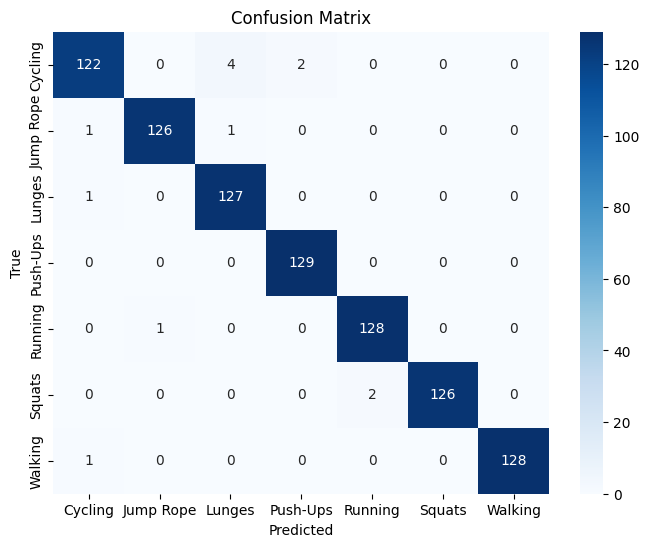

In [44]:
# 📊 STEP 11: Evaluate
# ===============================

y_pred = np.argmax(model.predict(X_test), axis=1)
acc = accuracy_score(y_test, y_pred)
print(f"✅ Test Accuracy: {acc*100:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

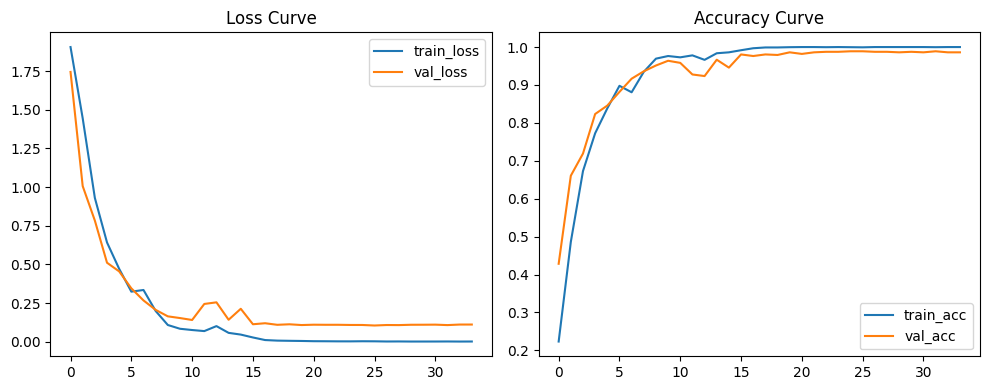

In [45]:
# 📈 STEP 12: Training curves
# ===============================

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend(); plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.legend(); plt.title("Accuracy Curve")

plt.tight_layout()
plt.show()